<a href="https://colab.research.google.com/github/hritik880/GANS-/blob/master/MNIST_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2 align=center>Generate Synthetic Images with DCGANs in Keras</h2>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def show(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image)
        plt.axis("off")

In [ ]:
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from tqdm import tqdm
from IPython import display
print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.2.0


In [ ]:
(x_train , y_train) , (x_test , y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype(np.float32)/ 255.0
x_test = x_test.astype(np.float32)/ 255.0

11493376/11490434 [==============================] - 0s 0us/step


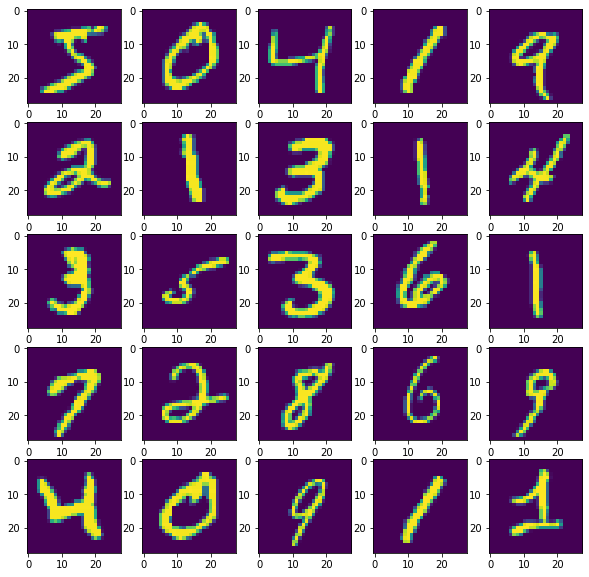

In [ ]:
plt.figure(figsize= (10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.grid(False)
    plt.imshow(x_train[i])
    

In [ ]:
x_train.shape

(60000, 28, 28)

In [ ]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(1000)
dataset = dataset.batch(batch_size,drop_remainder = True).prefetch(1)

**Generator** is an upsampling network with fractionally-strided convolutions

**Discriminator** is a convolutional network

Architecture guidelines for stable Deep Convolutional GANs:

- Replace any pooling layers with strided convolutions (discriminator) and fractional-strided convolutions (generator).
- Use batchnorm in both the generator and the discriminator.
- Remove fully connected hidden layers for deeper architectures.
- Use ReLU activation in generator for all layers expect for the output, which uses Tanh.
- Use LeakyReLU activation in the discriminator for all layers.

[Source](https://arxiv.org/pdf/1511.06434.pdf): Radford et al, "*Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks*", ICLR 2016

In [ ]:
num_features = 100
generator = keras.models.Sequential([
    keras.layers.Dense(7*7*128 ,input_shape = [num_features],activation = 'relu'),
    keras.layers.Reshape([7,7,128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64,(5,5), (2,2),padding = 'same', activation = 'relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1,(5,5), (2,2),padding = 'same', activation = 'tanh')
])

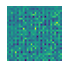

In [ ]:
noise = tf.random.normal(shape = [1,num_features])
generated_image = generator(noise,training = False)
show(generated_image, 1 )

In [ ]:
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, (5,5) ,  (2,2) , padding ='same', input_shape =[28,28,1]),
    keras.layers.LeakyReLU(0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(128,(5,5), (2,2),padding = 'same'),
    keras.layers.LeakyReLU(0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation = 'sigmoid')
])

In [ ]:
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.49961478]], shape=(1, 1), dtype=float32)


In [ ]:
discriminator.compile(loss = 'binary_crossentropy', optimizer = 'adam')
discriminator.trainable  = False
gan= keras.models.Sequential([generator,discriminator])
gan.compile(loss = 'binary_crossentropy', optimizer = 'adam')


In [ ]:
seed = tf.random.normal(shape = [batch_size , 100])

In [ ]:
def train_dcgan(gan , dataset ,batch_size , num_features, epochs = 5):
    generator, discriminator = gan.layers
    for epoch in tqdm(range(epochs)):
        print("epoch {}/{}".format(epoch + 1 ,epochs))
        for X_batch in dataset:
            #creating random noise of shape (batch_size ,num_of_features)
            noise = tf.random.normal(shape = [batch_size,num_features])
            #initilally generating image from untrained generator to train discriminator
            generated_images = generator(noise)
            #concatinating images
            X_fake_and_real = tf.concat([generated_images,X_batch],axis =0)
            # creating a list y1 which contains true_labels for images
            y1 = tf.constant([[0.]]*batch_size + [[0.9]]*batch_size) 
            #training the discriminaator 
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real,y1)
            #training generator now
            y2 = tf.constant([[1.0]]*batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise,y2)
        display.clear_output(wait = True)
        generate_and_save_images(generator, epoch+1 ,seed)
    display.clear_output(wait = True)
    generate_and_save_images(generator, epochs , seed)

In [ ]:
## Source https://www.tensorflow.org/tutorials/generative/dcgan#create_a_gif
output_dir = r'/content/drive/My Drive/mnist'
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(10,10))
    
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='binary')
        plt.axis('off')
        
    plt.savefig(output_dir + '/image_at_epoch_{:04d}.png'.format(epoch + 50))
    plt.show()

In [ ]:
x_train_dcgan =  x_train.reshape(-1,28,28,1)* 2. -1

In [ ]:
batch_size = 32
dataset =  tf.data.Dataset.from_tensor_slices(x_train_dcgan).shuffle(1000)
dataset = dataset.batch(batch_size,drop_remainder = True).prefetch(1)

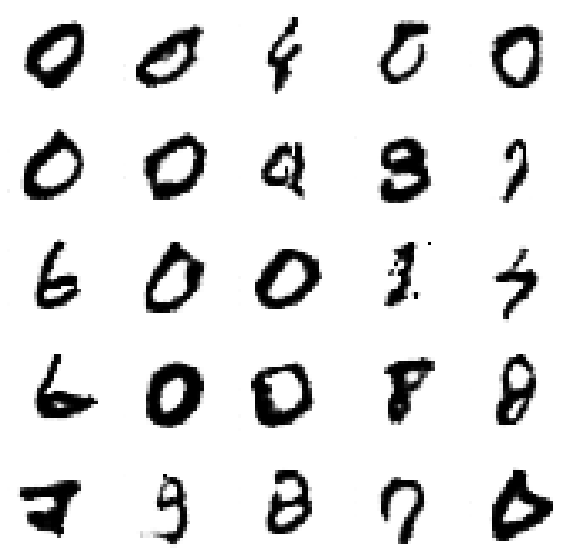

CPU times: user 36min 24s, sys: 2min 40s, total: 39min 5s
Wall time: 54min 40s


In [ ]:
%%time
train_dcgan(gan,dataset, batch_size, num_features,epochs =50)

## Task 9: Generate Synthetic Images with DCGAN

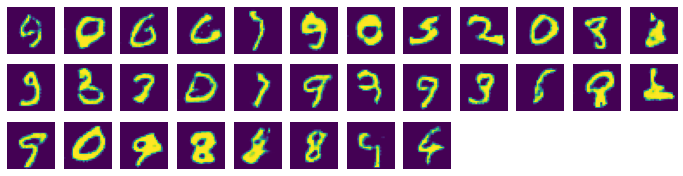

In [ ]:
noise = tf.random.normal(shape = [batch_size,num_features])
generated_images = generator(noise)
show(generated_images,12)